In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data_user = pd.read_excel('inputfile/cph.xlsx', header=0)
data_user['缴费日期'] = pd.to_datetime(data_user['缴费日期']) # 确保'缴费日期'为日期格式
data_user.head()

,用户编号,缴费日期,缴费金额（元）
0,1000000001,2018-03-01,101
1,1000000001,2018-05-03,80
2,1000000001,2018-07-02,150
3,1000000001,2018-08-02,200
4,1000000001,2018-09-05,220


### 数据预处理

In [3]:
groupby_usernumber = data_user.groupby(data_user['用户编号'], as_index=False).agg({
    '缴费日期': 'count', '缴费金额（元）': 'sum'})  # 按用户编号分组,统计缴费次数和缴费总金额
groupby_usernumber.rename(
    columns={'缴费日期': '缴费次数', '缴费金额（元）': '缴费总金额'}, inplace=True)
groupby_usernumber.head()

,用户编号,缴费次数,缴费总金额
0,1000000001,8,987
1,1000000002,7,490
2,1000000003,7,1180
3,1000000004,8,621
4,1000000005,7,1500


In [4]:
sum_time = []# 每个用户缴费总时间间隔
max_time = []# 缴费最长时间间隔
min_time = []# 缴费最短时间间隔
stime=0
maxtime=0
mintime=365

for i in range(1,data_user.shape[0]):
    if data_user.iloc[i,0]==data_user.iloc[i-1,0]:# 当前记录与前一个记录是同一个用户
        stime+=(data_user.iloc[i,1]-data_user.iloc[i-1,1]).days
        if (data_user.iloc[i,1]-data_user.iloc[i-1,1]).days>maxtime:
            maxtime = (data_user.iloc[i,1]-data_user.iloc[i-1,1]).days
        if (data_user.iloc[i,1]-data_user.iloc[i-1,1]).days<mintime:
            mintime = (data_user.iloc[i,1]-data_user.iloc[i-1,1]).days

    else:
        sum_time.append(stime)
        max_time.append(maxtime)
        min_time.append(mintime)
        stime=0
        maxtime=0
        mintime=365
    if i==data_user.shape[0]-1:
        sum_time.append(stime)
        max_time.append(maxtime)
        min_time.append(mintime)
        
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='缴费总天数', value=sum_time)
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='缴费最长时间间隔', value=max_time)
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='缴费最短时间间隔', value=min_time)


In [5]:
groupby_usernumber.head()

,用户编号,缴费次数,缴费总金额,缴费总天数,缴费最长时间间隔,缴费最短时间间隔
0,1000000001,8,987,369,64,31
1,1000000002,7,490,368,68,55
2,1000000003,7,1180,369,65,59
3,1000000004,8,621,366,65,26
4,1000000005,7,1500,367,65,59


In [6]:
# 极小型指标正向化
time_day = max(groupby_usernumber['缴费总天数']/(groupby_usernumber['缴费次数']-1))-groupby_usernumber['缴费总天数']/(groupby_usernumber['缴费次数']-1)
long_day = max(groupby_usernumber['缴费最长时间间隔'])-groupby_usernumber['缴费最长时间间隔']
short_day = max(groupby_usernumber['缴费最短时间间隔'])-groupby_usernumber['缴费最短时间间隔']

# 插入datafream
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='平均缴费间隔正向化', value=time_day)
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='缴费最长时间间隔正向化', value=long_day)
groupby_usernumber.insert(loc=len(groupby_usernumber.columns), column='缴费最短时间间隔正向化', value=short_day)

In [7]:
groupby_usernumber.head()

,用户编号,缴费次数,缴费总金额,缴费总天数,缴费最长时间间隔,缴费最短时间间隔,平均缴费间隔正向化,缴费最长时间间隔正向化,缴费最短时间间隔正向化
0,1000000001,8,987,369,64,31,69.952381,187,29
1,1000000002,7,490,368,68,55,61.333333,183,5
2,1000000003,7,1180,369,65,59,61.166667,186,1
3,1000000004,8,621,366,65,26,70.380952,186,34
4,1000000005,7,1500,367,65,59,61.500000,186,1


In [8]:
# 最大最小归一化
from sklearn.preprocessing import MinMaxScaler

cols = [col for col in groupby_usernumber.columns if col not in ['用户编号', '缴费总天数','缴费最长时间间隔','缴费最短时间间隔']]  # 选取特征

maxmin_data = MinMaxScaler().fit_transform(groupby_usernumber[cols])

# 存储到DataFrame
maxmin_data = pd.DataFrame(maxmin_data)
maxmin_data.columns = cols
# 查看
maxmin_data.head()

,缴费次数,缴费总金额,平均缴费间隔正向化,缴费最长时间间隔正向化,缴费最短时间间隔正向化
0,1.0,0.588283,0.993911,0.994681,0.805556
1,0.8,0.189406,0.871448,0.973404,0.138889
2,0.8,0.743178,0.869080,0.989362,0.027778
3,1.0,0.294543,1.000000,0.989362,0.944444
4,0.8,1.000000,0.873816,0.989362,0.027778


In [9]:
from sklearn.cluster import KMeans# K-Mmeans算法

k = 4   # 聚类数 

# 确定聚类中心数 # 构建模型，随机种子设为123 
# 读取标准化后的数据 
kmeans_model = KMeans(n_clusters=k, n_jobs=4, random_state=123)
# 模型训练
fit_kmeans = kmeans_model.fit(maxmin_data)                

# 查看聚类结果 
# 聚类中心 
kmeans_cc = kmeans_model.cluster_centers_ 
print('各类聚类中心为：\n',kmeans_cc)                          

# 样本的类别标签 
kmeans_labels = kmeans_model.labels_ 
print('各样本的类别标签为：\n',kmeans_labels) 

# 统计不同类别样本的数目 
r1 = pd.Series(kmeans_model.labels_).value_counts()        
print('最终每个类别的数目为：\n',r1) 

# 输出聚类分群的结果 
cluster_center = pd.DataFrame(kmeans_model.cluster_centers_,columns = maxmin_data.columns) 

# 将聚类中心放在数据框中 
cluster_center.index = pd.DataFrame(kmeans_model.labels_ ).drop_duplicates().iloc[:,0]         

 # 将样本类别作为数据框索引 
print(cluster_center)

各类聚类中心为：
 [[0.78235294 0.40452979 0.87217922 0.97598561 0.09844771]
 [0.91111111 0.37149991 0.93507743 0.92966903 0.81790123]
 [0.52       0.23900482 0.74751522 0.77606383 0.0625    ]
 [0.33333333 0.19448903 0.29166667 0.2322695  0.07407407]]
各样本的类别标签为：
 [1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0 2 3 0 0 0 0 2 0 0 0 2 2 0 0 0 0
 2 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 2 0 0 0 0 1 0 0 0 1 2 0 2 0 0 2 1 0 0 3 0
 0 0 0 3 2 1 0 2 0 0 0 2 0 0 2 0 0 2 2 0 0 0 1 0 2 0]
最终每个类别的数目为：
 0    68
2    20
1     9
3     3
dtype: int64
       缴费次数     缴费总金额  平均缴费间隔正向化  缴费最长时间间隔正向化  缴费最短时间间隔正向化
0                                                         
1  0.782353  0.404530   0.872179     0.975986     0.098448
0  0.911111  0.371500   0.935077     0.929669     0.817901
2  0.520000  0.239005   0.747515     0.776064     0.062500
3  0.333333  0.194489   0.291667     0.232270     0.074074


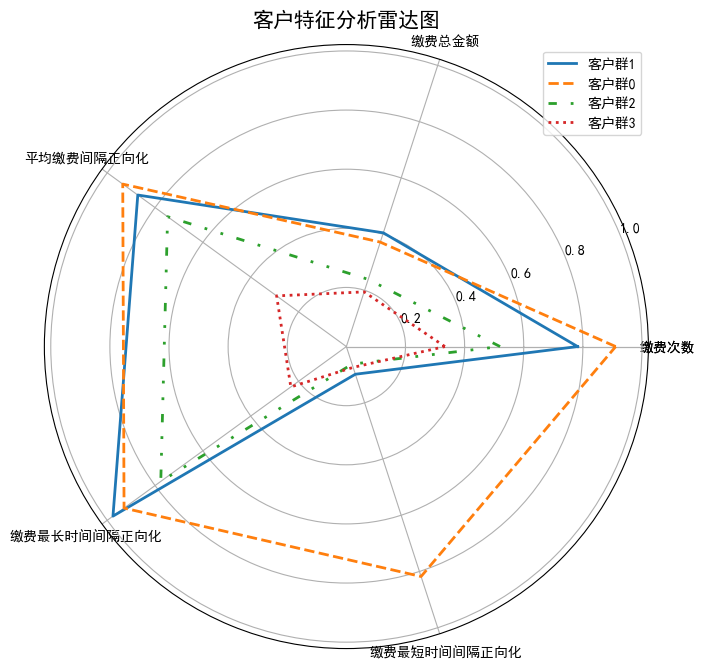

<function matplotlib.pyplot.close(fig=None)>

In [10]:
import matplotlib.pyplot as plt 
# 客户分群雷达图
labels = maxmin_data.columns
# labels=['缴费次数', '缴费总金额', '平均缴费间隔正向化', '缴费最长时间间隔正向化', '缴费最短时间间隔正向化']
legen = ['客户群' + str(i) for i in cluster_center.index]  # 客户群命名，作为雷达图的图例
linestype = ['-','--',(0, (3, 5, 1, 5, 1, 5)),':','-.']
kinds = list(cluster_center.iloc[:, 0])
# 由于雷达图要保证数据闭合，因此再添加L列，并转换为 np.ndarray
cluster_center = pd.concat([cluster_center, cluster_center[['缴费次数']]], axis=1)
centers = np.array(cluster_center.iloc[:, 0:])

# 分割圆周长，并让其闭合
n = len(labels)
angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
angle = np.concatenate((angle, [angle[0]]))
labels=np.concatenate((labels,[labels[0]]))   #对labels进行封闭

# 绘图
fig = plt.figure(figsize = (8,8),dpi=100)
ax = fig.add_subplot(111, polar=True)  # 以极坐标的形式绘制图形

# 画线
for i in range(len(kinds)):
    ax.plot(angle, centers[i], linestyle=linestype[i], linewidth=2, label=kinds[i])
# 添加属性标签
ax.set_thetagrids(angle * 180 / np.pi, labels)
plt.title('客户特征分析雷达图',fontsize=15)
plt.legend(legen)
plt.show()
plt.close

In [11]:
# 将聚类后的标签插入datafream
maxmin_data.insert(loc=len(maxmin_data.columns), column='label', value=kmeans_labels)
maxmin_data.insert(loc=0, column='用户编号', value=groupby_usernumber['用户编号'])

maxmin_data.head()

,用户编号,缴费次数,缴费总金额,平均缴费间隔正向化,缴费最长时间间隔正向化,缴费最短时间间隔正向化,label
0,1000000001,1.0,0.588283,0.993911,0.994681,0.805556,1
1,1000000002,0.8,0.189406,0.871448,0.973404,0.138889,0
2,1000000003,0.8,0.743178,0.869080,0.989362,0.027778,0
3,1000000004,1.0,0.294543,1.000000,0.989362,0.944444,1
4,1000000005,0.8,1.000000,0.873816,0.989362,0.027778,0


In [12]:
# 提取潜力型用户
qianli_data = maxmin_data[maxmin_data['label']==1].iloc[:,1:-1] # 潜力用户数据
qianli_user = maxmin_data[maxmin_data['label']==1].iloc[:,0] # 潜力用户ID
qianli_data.head()

,缴费次数,缴费总金额,平均缴费间隔正向化,缴费最长时间间隔正向化,缴费最短时间间隔正向化
0,1.0,0.588283,0.993911,0.994681,0.805556
3,1.0,0.294543,1.000000,0.989362,0.944444
9,1.0,0.416533,0.995940,0.994681,0.805556
15,1.0,0.425361,1.000000,0.978723,1.000000
58,1.0,0.390048,0.989851,0.989362,0.833333


In [13]:
# 熵权法赋权
yij = qianli_data.apply(lambda x: x / x.sum(), axis=0) # 第i个用户的第j个指标值的比重yij = xij/sum(xij) i=(1,m)
K = 1/np.log(len(qianli_data)) # 常数
tmp = yij*np.log(yij)
tmp=np.nan_to_num(tmp)
ej = -K*(tmp.sum(axis=0)) # 计算第j个指标的信息熵
wj = (1 - ej) / np.sum(1 - ej) # 计算第j个指标的权重
score = yij.apply(lambda x: np.sum(100 * x * wj), axis=1)
# top5 = heapq.nlargest(5,score)


qianli_data['得分'] = pd.DataFrame(score)
qianli_data.insert(loc=0, column='用户编号', value=qianli_user.values)

result = qianli_data.sort_values(by="得分",ascending=False).iloc[0:5,0]
result #结果

0     1000000001
15    1000000016
9     1000000010
58    1000000059
69    1000000070
Name: 用户编号, dtype: int64

In [14]:
# 输出csv文件
result.to_csv('outputfile/居民客户的用电缴费习惯分析 3.csv',index=False,encoding='gbk')
